# Norepinephrine-to-fluid ratio (NFR) in septic patients

## Import libraries etc.

In [165]:
# Import Pandas, Numpy and SQL-Connection
import numpy as np
import pandas as pd
import psycopg2

# Import ML- and statistic tools
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from math import sqrt
import scipy.stats as stats

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Import AmsterdamUMCdb
import amsterdamumcdb as adb

# Import local code
import adbcalc as ac

# Import graphviz
import graphviz
from graphviz import Digraph

# Import stats
from scipy.stats import pointbiserialr

### Connection

In [166]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('config.ini'):
    config.read('config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

### ROC-AUC Confidence interval calculation

In [167]:
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (round(lower, 2), round(upper, 2))

## Data preparation

### Define observation period in ms

In [168]:
fluid_period = 3 * 24 * 60 * 60 * 1000

### Execute SQL queries

In [169]:
# Intake of crystalloids
query = open('./sql/crystalloids.sql', 'r')
crystalloids = pd.read_sql_query(query.read(), con, params={"fluid_period": fluid_period})

In [170]:
# Intake of colloids
query = open('./sql/colloids.sql', 'r')
colloids = pd.read_sql_query(query.read(), con, params={"fluid_period": fluid_period})

In [171]:
# Intake of blood products
query = open('./sql/bloodproducts.sql', 'r')
bloodproducts = pd.read_sql_query(query.read(), con, params={"fluid_period": fluid_period})

In [172]:
# Intake of norepinephrine
query = open('./sql/norepinephrine.sql', 'r')
norepinephrine = pd.read_sql_query(query.read(), con, params={"fluid_period": fluid_period})

### Calculate cumulative doses

In [173]:
# Calculate the norepinephrine dose in microgram (mcg) for every episode of norepinephrine infusion
norepi_mcg = [ac.calculate_dose(norepinephrine['start'][i], \
                                          norepinephrine['stop'][i], \
                                          fluid_period, \
                                          norepinephrine['dose'][i], \
                                          1)
              for i in norepinephrine.index]

In [174]:
# Calculate the crystalloid volume in mililiters (ml) for every episode of crystalloid infusion
crystalloids_ml = [ac.calculate_dose(crystalloids['start'][i], \
                                          crystalloids['stop'][i], \
                                          fluid_period, \
                                          crystalloids['dose'][i], \
                                          2)
              for i in crystalloids.index]

In [175]:
# Calculate the colloid volume in mililiters (ml) for every episode of colloid infusion
colloids_ml = [ac.calculate_dose(colloids['start'][i], \
                                          colloids['stop'][i], \
                                          fluid_period, \
                                          colloids['dose'][i], \
                                          2)
              for i in colloids.index]

In [176]:
# Calculate the bloodproducts volume in mililiters (ml) for every episode of bloodproduct infusion
bloodproducts_ml = [ac.calculate_dose(bloodproducts['start'][i], \
                                          bloodproducts['stop'][i], \
                                          fluid_period, \
                                          bloodproducts['dose'][i], \
                                          2)
              for i in bloodproducts.index]

In [177]:
# Add columns with cumulative dose
norepinephrine['norepi_mcg'] = norepi_mcg
crystalloids['crystalloids_ml'] = crystalloids_ml
colloids['colloids_ml'] = colloids_ml
bloodproducts['bloodproducts_ml'] = bloodproducts_ml

In [178]:
# Sum up all intervals
norepinephrine_sum = norepinephrine[['admissionid', 'norepi_mcg']].groupby(['admissionid']).sum()
norepinephrine_max = norepinephrine[['admissionid', 'dose', 'stop']].groupby(['admissionid']).max().rename({'dose': 'norepi_max_dose', 'stop': 'norepi_max_dose_stop'}, axis='columns')
crystalloids_sum = crystalloids[['admissionid', 'crystalloids_ml']].groupby(['admissionid']).sum()
colloids_sum = colloids[['admissionid', 'colloids_ml']].groupby(['admissionid']).sum()
bloodproducts_sum = bloodproducts[['admissionid', 'bloodproducts_ml']].groupby(['admissionid']).sum()

### Merge Pandas DataFrames

In [179]:
# Import septic patients based on the reason_for_admission.ipynb
# where-condition for 'dateofdeath' is != 0 instead of > 0 to include all patients with a negative date of death.
# According to an issue raised at GitHub, a negative 'dateofdeath' can occur if a patient has died early after admission. 

sepsis = pd.read_csv('sepsis.csv')[['admissionid', 'patientid', 'admissioncount', 'diagnosis_group', 'agegroup', 'weightgroup', 'gender', 'dateofdeath']]
sepsis['dateofdeath'] = sepsis['dateofdeath'].fillna(0)
sepsis['died'] = np.where(sepsis['dateofdeath'] != 0 , 1, 0)
sepsis['died07'] = np.where((sepsis['dateofdeath'] != 0) & (sepsis['dateofdeath'] < 604800000), 1, 0)
sepsis['died28'] = np.where((sepsis['dateofdeath'] != 0) & (sepsis['dateofdeath'] < 2419200000), 1, 0)

In [180]:
# Merge DataFrames
intake = pd.merge(sepsis, crystalloids_sum, how = 'left', on = 'admissionid') \
    .merge(colloids_sum, on = 'admissionid', how = 'left') \
    .merge(bloodproducts_sum, on = 'admissionid', how = 'left') \
    .merge(norepinephrine_sum, on = 'admissionid', how = 'left') \
    .merge(norepinephrine_max, on = 'admissionid', how = 'left')

### Fill NA and drop out patients w/o norepinephrine or fluids

In [181]:
# Fill NULL-values with 0
intake['died'] = intake['died'].fillna(0)
intake['crystalloids_ml'] = intake['crystalloids_ml'].fillna(0)
intake['colloids_ml'] = intake['colloids_ml'].fillna(0)
intake['bloodproducts_ml'] = intake['bloodproducts_ml'].fillna(0)
intake['norepi_mcg'] = intake['norepi_mcg'].fillna(0)
intake['total_fluids'] = intake['crystalloids_ml'] + intake['colloids_ml'] + intake['bloodproducts_ml']
intake['nf_ratio'] = intake['norepi_mcg'] / intake['total_fluids']

In [182]:
# Test if pandas merge is plausible
print('Sepsis: ', len(sepsis))
print('Crystalloids rows: ', len(crystalloids))
print('Colloids rows: ', len(colloids))
print('Blood products rows: ', len(bloodproducts))
print('Norepinephrine rows: ', len(norepinephrine))
print('Merged DataFrame rows: ', len(intake))

Sepsis:  3136
Crystalloids rows:  245001
Colloids rows:  31593
Blood products rows:  17634
Norepinephrine rows:  119987
Merged DataFrame rows:  3136


In [183]:
print('No Norepinephrine: ', len(intake[intake['norepi_mcg'] == 0]))
print('No fluids: ', len(intake[intake['total_fluids'] == 0]))

No Norepinephrine:  1200
No fluids:  300


In [184]:
# Drop rows without norepinephrine and without fluids
#intake = intake.drop(intake[(intake.norepinephrine_dose_mcg == 0) & (intake.total_fluids == 0)].index)
intake = intake.drop(intake[(intake.norepi_mcg == 0) | \
                            (intake.norepi_max_dose == 0) | \
                            (intake.total_fluids == 0) | \
                            (intake.nf_ratio == 0)].index)

## Demographics

In [185]:
diagnosis = intake[['admissionid', 'diagnosis_group']].groupby(['diagnosis_group']).count()

In [186]:
intake[['admissionid', 'agegroup']].groupby(['agegroup']).count()

,admissionid
agegroup,
18-39,187
40-49,210
50-59,311
60-69,463
70-79,479
80+,286


In [187]:
print('Male: ', len(intake[intake['gender'] == 'Man']))
print('Female: ', len(intake[intake['gender'] == 'Vrouw']))
print('Unknown: ', len(intake[intake['gender'] != 'Vrouw']))

Male:  1125
Female:  752
Unknown:  1184


## Statistics

### Overall descriptive stats

In [188]:
# Select 
intake_survived = intake[['died', 'dateofdeath', 'crystalloids_ml', 'colloids_ml', 'bloodproducts_ml', 'norepi_mcg', 'norepi_max_dose', 'total_fluids', 'nf_ratio']][intake['died'] == 0]
intake_died = intake[['died', 'dateofdeath', 'crystalloids_ml', 'colloids_ml', 'bloodproducts_ml', 'norepi_mcg', 'norepi_max_dose', 'total_fluids', 'nf_ratio']][intake['died'] == 1]
intake_died07 = intake[['died07', 'dateofdeath', 'crystalloids_ml', 'colloids_ml', 'bloodproducts_ml', 'norepi_mcg', 'norepi_max_dose', 'total_fluids', 'nf_ratio']][intake['died07'] == 1]
intake_died28 = intake[['died28', 'dateofdeath', 'crystalloids_ml', 'colloids_ml', 'bloodproducts_ml', 'norepi_mcg', 'norepi_max_dose', 'total_fluids', 'nf_ratio']][intake['died28'] == 1]

In [189]:
#intake_survived.describe()

In [190]:
#intake_survived.median()

In [191]:
#intake_died.describe()

In [192]:
#intake_died07.describe()

In [193]:
#intake_died28.describe()

In [194]:
#intake['nf_ratio'].describe()

In [195]:
#intake['norepi_max_dose'].describe()

### NFR descriptive stats

In [196]:
#intake['nf_ratio'][intake['died07'] ==0].describe()

In [197]:
#intake['nf_ratio'][intake['died07'] ==1].describe()

### Point-biserial correlation

In [198]:
pbc07 = pointbiserialr(intake['died07'], intake['nf_ratio'])
pbc28 = pointbiserialr(intake['died28'], intake['nf_ratio'])
pbc07_norepi = pointbiserialr(intake['died07'], intake['norepi_mcg'])
pbc28_norepi = pointbiserialr(intake['died28'], intake['norepi_mcg'])
pbc07_fluids = pointbiserialr(intake['died07'], intake['total_fluids'])
pbc28_fluids = pointbiserialr(intake['died28'], intake['total_fluids'])

print('NFR 7-day:', pbc07)
print('NFR 28-day:', pbc28)
print('Norepinpehrine 7-day:', pbc07_norepi)
print('Norepinpehrine 28-day:', pbc28_norepi)
print('Fluids 7-day:', pbc07_fluids)
print('Fluids 28-day:', pbc28_fluids)

NFR 7-day: PointbiserialrResult(correlation=0.19885501111387427, pvalue=1.0252934331518585e-18)
NFR 28-day: PointbiserialrResult(correlation=0.21218937191409204, pvalue=3.800659183885538e-21)
Norepinpehrine 7-day: PointbiserialrResult(correlation=0.21725491068645755, pvalue=4.0934986124189335e-22)
Norepinpehrine 28-day: PointbiserialrResult(correlation=0.2453913042073014, pvalue=6.0685640636973175e-28)
Fluids 7-day: PointbiserialrResult(correlation=0.015770458589901542, pvalue=0.48799887173999396)
Fluids 28-day: PointbiserialrResult(correlation=0.03501108546924429, pvalue=0.12356890112174063)


### ROC AUC and Youden-Index

In [199]:
# Area under curve score is calculated using sklearn.metrics
# Youden index is calculated as the maximal value of true positive rate (tpr) - false positive rate (fpr) 
# (= 1 - specificity)

# NFR
auc07 = roc_auc_score(intake['died07'], intake['nf_ratio'])
fpr07, tpr07, thresholds07 = roc_curve(intake['died07'], intake['nf_ratio'])
optimal_cutoff_pos07 = np.argmax(tpr07 - fpr07)
optimal_cutoff07 = thresholds07[optimal_cutoff_pos07]
youden_index07 = (tpr07 - fpr07)[optimal_cutoff_pos07]
auroc_ci07 = roc_auc_ci(intake['died07'], intake['nf_ratio'])
sensitivity07 = tpr07[140]
specificity07 = 1-fpr07[140]

auc28 = roc_auc_score(intake['died28'], intake['nf_ratio'])
fpr28, tpr28, thresholds28 = roc_curve(intake['died28'], intake['nf_ratio'])
optimal_cutoff_pos28 = np.argmax(tpr28 - fpr28)
optimal_cutoff28 = thresholds28[optimal_cutoff_pos28]
youden_index28 = (tpr28 - fpr28)[optimal_cutoff_pos28]
auroc_ci28 = roc_auc_ci(intake['died28'], intake['nf_ratio'])
sensitivity28 = tpr28[148]
specificity28 = 1-fpr28[148]

# Norepinephrine
auc07_norepi = roc_auc_score(intake['died07'], intake['norepi_mcg'])
fpr07_norepi, tpr07_norepi, thresholds07_norepi = roc_curve(intake['died07'], intake['norepi_mcg'])
optimal_cutoff_pos07_norepi = np.argmax(tpr07_norepi - fpr07_norepi)
optimal_cutoff07_norepi = thresholds07_norepi[optimal_cutoff_pos07_norepi]
youden_index07_norepi = (tpr07_norepi - fpr07_norepi)[optimal_cutoff_pos07_norepi]
auroc_ci07_norepi = roc_auc_ci(intake['died07'], intake['norepi_mcg'])
sensitivity07_norepi = tpr07_norepi[126]
specificity07_norepi = 1-fpr07_norepi[126]

auc28_norepi = roc_auc_score(intake['died28'], intake['norepi_mcg'])
fpr28_norepi, tpr28_norepi, thresholds28_norepi = roc_curve(intake['died28'], intake['norepi_mcg'])
optimal_cutoff_pos28_norepi = np.argmax(tpr28_norepi - fpr28_norepi)
optimal_cutoff28_norepi = thresholds28_norepi[optimal_cutoff_pos28_norepi]
youden_index28_norepi = (tpr28_norepi - fpr28_norepi)[optimal_cutoff_pos28_norepi]
auroc_ci28_norepi = roc_auc_ci(intake['died28'], intake['norepi_mcg'])
sensitivity28_norepi = tpr28_norepi[168]
specificity28_norepi = 1-fpr28_norepi[168]

# Fluid intake
auc07_fluids = roc_auc_score(intake['died07'], intake['total_fluids'])
fpr07_fluids, tpr07_fluids, thresholds07_fluids = roc_curve(intake['died07'], intake['total_fluids'])
optimal_cutoff_pos07_fluids = np.argmax(tpr07_fluids - fpr07_fluids)
optimal_cutoff07_fluids = thresholds07_fluids[optimal_cutoff_pos07_fluids]
youden_index07_fluids = (tpr07_fluids - fpr07_fluids)[optimal_cutoff_pos07_fluids]
auroc_ci07_fluids = roc_auc_ci(intake['died07'], intake['total_fluids'])
sensitivity07_fluids = tpr07_fluids[35]
specificity07_fluids = 1-fpr07_fluids[35]

auc28_fluids = roc_auc_score(intake['died28'], intake['total_fluids'])
fpr28_fluids, tpr28_fluids, thresholds28_fluids = roc_curve(intake['died28'], intake['total_fluids'])
optimal_cutoff_pos28_fluids = np.argmax(tpr28_fluids - fpr28_fluids)
optimal_cutoff28_fluids = thresholds28_fluids[optimal_cutoff_pos28_fluids]
youden_index28_fluids = (tpr28_fluids - fpr28_fluids)[optimal_cutoff_pos28_fluids]
auroc_ci28_fluids = roc_auc_ci(intake['died28'], intake['total_fluids'])
sensitivity28_fluids = tpr28_fluids[57]
specificity28_fluids = 1-fpr28_fluids[57]

print('Observation period:', fluid_period / (24 * 60 * 60 * 1000), 'days')
print()
print('NFR AUROC 7-day mortality:', round(auc07, 2))
print('NFR AUROC 7-day mortality confidence interval:', auroc_ci07)
print('NFR Youden-Index 7-day mortality:' , round(youden_index07, 2))
print('NFR Optimal cut-off 7-day mortality:', round(optimal_cutoff07, 2))
print('NFR Sensitivity 7-day mortality:', round(sensitivity07, 2))
print('NFR Specificity 7-day mortality:', round(specificity07, 2))
print()
print('NFR AUROC 28-day mortality:', round(auc28, 2))
print('NFR AUC-ROC 28-day mortality confidence interval:', auroc_ci28)
print('NFR Youden-Index 28-day mortality:' , round(youden_index28, 2))
print('NFR Optimal cut-off 28-day mortality:', round(optimal_cutoff28, 2))
print('NFR Sensitivity 28-day mortality:', round(sensitivity28, 2))
print('NFR Specificity 28-day mortality:', round(specificity28, 2))
print()
print('Norepinephrine AUROC 7-day mortality:', round(auc07_norepi, 2))
print('Norepinephrine AUROC 7-day mortality confidence interval:', auroc_ci07_norepi)
print('Norepinephrine Youden-Index 7-day mortality:' , round(youden_index07_norepi, 2))
print('Norepinephrine optimal cut-off 7-day mortality:', round(optimal_cutoff07_norepi, 2))
print('Norepinephrine Sensitivity 7-day mortality:', round(sensitivity07_norepi, 2))
print('Norepinephrine Specificity 7-day mortality:', round(specificity07_norepi, 2))
print()
print('Norepinephrine AUROC 28-day mortality:', round(auc28_norepi, 2))
print('Norepinpehrine AUROC 28-day mortality confidence interval:', auroc_ci28_norepi)
print('Norepinheprine Youden-Index 28-day mortality:' , round(youden_index28_norepi, 2))
print('Norepinpehrine Optimal cut-off 28-day mortality:', round(optimal_cutoff28_norepi, 2))
print('Norepinephrine Sensitivity 28-day mortality:', round(sensitivity28_norepi, 2))
print('Norepinephrine Specificity 28-day mortality:', round(specificity28_norepi, 2))
print()
print('Fluids AUROC 7-day mortality:', round(auc07_fluids, 2))
print('Fluids AUROC 7-day mortality confidence interval:', auroc_ci07_fluids)
print('Fluids Youden-Index 7-day mortality:' , round(youden_index07_fluids, 2))
print('Fluids optimal cut-off 7-day mortality:', round(optimal_cutoff07_fluids, 2))
print('Fluids Sensitivity 7-day mortality:', round(sensitivity07_fluids, 2))
print('Fluids Specificity 7-day mortality:', round(specificity07_fluids, 2))
print()
print('Fluids AUROC 28-day mortality:', round(auc28_fluids, 2))
print('Fluids AUROC 28-day mortality confidence interval:', auroc_ci28_fluids)
print('Fluids Youden-Index 28-day mortality:' , round(youden_index28_fluids, 2))
print('Fluids optimal cut-off 28-day mortality:', round(optimal_cutoff28_fluids, 2))
print('Fluids Sensitivity 28-day mortality:', round(sensitivity28_norepi, 2))
print('Fluids Specificity 28-day mortality:', round(specificity28_norepi, 2))

Observation period: 3.0 days

NFR AUROC 7-day mortality: 0.71
NFR AUROC 7-day mortality confidence interval: (0.67, 0.74)
NFR Youden-Index 7-day mortality: 0.35
NFR Optimal cut-off 7-day mortality: 4.99
NFR Sensitivity 7-day mortality: 0.31
NFR Specificity 7-day mortality: 0.89

NFR AUROC 28-day mortality: 0.68
NFR AUC-ROC 28-day mortality confidence interval: (0.65, 0.7)
NFR Youden-Index 28-day mortality: 0.31
NFR Optimal cut-off 28-day mortality: 4.71
NFR Sensitivity 28-day mortality: 0.28
NFR Specificity 28-day mortality: 0.89

Norepinephrine AUROC 7-day mortality: 0.67
Norepinephrine AUROC 7-day mortality confidence interval: (0.63, 0.7)
Norepinephrine Youden-Index 7-day mortality: 0.26
Norepinephrine optimal cut-off 7-day mortality: 59283.33
Norepinephrine Sensitivity 7-day mortality: 0.27
Norepinephrine Specificity 7-day mortality: 0.9

Norepinephrine AUROC 28-day mortality: 0.66
Norepinpehrine AUROC 28-day mortality confidence interval: (0.63, 0.69)
Norepinheprine Youden-Index 2

### Odds ratio

In [234]:
# Create two-dimensional contingency table
ct07 = pd.crosstab(index = intake.died07, columns = intake.nf_ratio >= optimal_cutoff07)
ct28 = pd.crosstab(index = intake.died28, columns = intake.nf_ratio >= optimal_cutoff28)
print(ct07)

nf_ratio  False  True 
died07                
0           950    596
1           103    287


In [235]:
# Calculate odds-ratio
oddsratio07, pvalue07 = stats.fisher_exact(ct07)
oddsratio28, pvalue28 = stats.fisher_exact(ct28)
print("7-day mortality Odds-Ratio:", round(oddsratio07, 2), "p-Value:", pvalue07)
print("28-day mortality Odds-Ratio:", round(oddsratio28, 2), "p-Value:", pvalue28)

7-day mortality Odds-Ratio: 4.44 p-Value: 6.611642764653097e-36
28-day mortality Odds-Ratio: 3.57 p-Value: 4.147084831227955e-37


### Relative risk

In [239]:
rel_risk_nfr07 = round((ct07[True][1] / (ct07[True][1] + ct07[True][0])) \
/ (ct07[False][1] / (ct07[False][1] + ct07[False][0])), 2)

rel_risk_nfr28 = round((ct28[True][1] / (ct28[True][1] + ct28[True][0])) \
/ (ct28[False][1] / (ct28[False][1] + ct28[False][0])), 2)

print('Relative risk 7-day mortality:', round(rel_risk_nfr07, 2))
print('Relative risk 28-day mortality:', round(rel_risk_nfr28, 2))

Relative risk 7-day mortality: 3.32
Relative risk 28-day mortality: 2.37


## Plots

### ROC-Curve

In [204]:
sns.set_theme()
sns.set_style('whitegrid')

In [205]:
fpr07_df = pd.DataFrame({'fpr07': fpr07}).melt(var_name = 'fpr', value_name = 'fpr_val')
tpr07_df = pd.DataFrame({'tpr07': tpr07}).melt(var_name = 'tpr', value_name = 'tpr_val')
fpr28_df = pd.DataFrame({'fpr28': fpr28}).melt(var_name = 'fpr', value_name = 'fpr_val')
tpr28_df = pd.DataFrame({'tpr28': tpr28}).melt(var_name = 'tpr', value_name = 'tpr_val')

In [206]:
fprdf = fpr07_df.append(fpr28_df, ignore_index=True)
tprdf = tpr07_df.append(tpr28_df, ignore_index=True)
auc_values_lf = fprdf.join(tprdf)

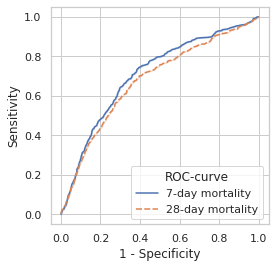

In [207]:
ax = sns.lineplot(x = 'fpr_val', 
                  y = 'tpr_val', 
                  hue = 'fpr', 
                  data = auc_values_lf,
                  style = "fpr")
ax.set_aspect("equal")
ax.set(xlabel = '1 - Specificity', ylabel = 'Sensitivity')
ax.legend(title='ROC-curve', loc='lower right', labels=['7-day mortality', '28-day mortality'])

# Save plot
plt.savefig('img/auroc.png', dpi=300)

### Distribution

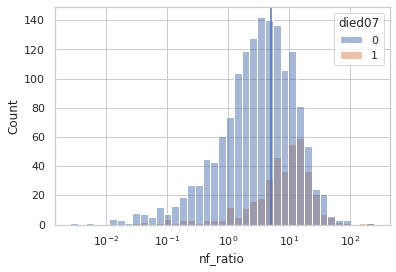

In [208]:
sns.histplot(x = 'nf_ratio', data = intake, hue='died07', log_scale=True)
plt.axvline(optimal_cutoff07)

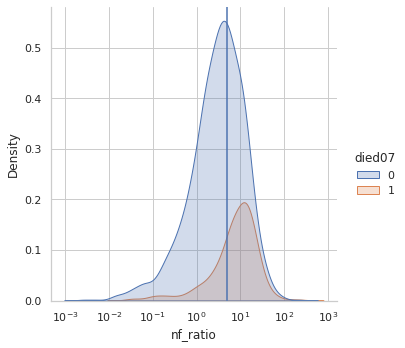

In [209]:
sns.displot(x = 'nf_ratio', data = intake, hue='died07', kind='kde', log_scale=True, fill=True)
plt.axvline(optimal_cutoff07)

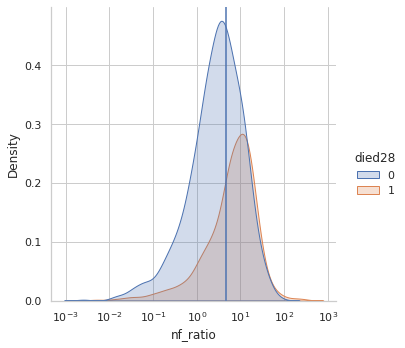

In [210]:
sns.displot(x = 'nf_ratio', data = intake, hue='died28', kind='kde', log_scale=True, fill=True)
plt.axvline(optimal_cutoff28)

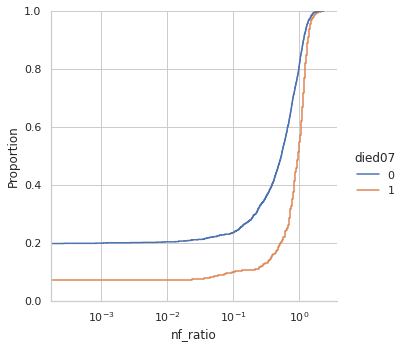

In [211]:
sns.displot(x = 'nf_ratio', data = intake, hue='died07', log_scale=True, kind='ecdf')

### Boxplot

In [212]:
lf07 = intake[['died07']].melt(value_name='died').join(intake[['nf_ratio']].melt(var_name='nfr', value_name='nfratio'))
lf28 = intake[['died28']].melt(value_name='died').join(intake[['nf_ratio']].melt(var_name='nfr', value_name='nfratio'))

In [213]:
boxplot_lf = lf07.append(lf28, ignore_index=True)

In [214]:
boxplot_lf.head()

,variable,died,nfr,nfratio
0,died07,1,nf_ratio,15.373978
1,died07,0,nf_ratio,0.882328
2,died07,1,nf_ratio,6.154514
3,died07,0,nf_ratio,11.188008
4,died07,0,nf_ratio,6.201379


<AxesSubplot:xlabel='died', ylabel='nfratio'>

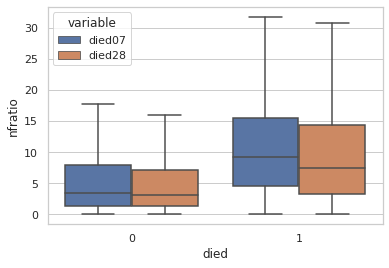

In [215]:
sns.boxplot(x = 'died', y = 'nfratio', hue = 'variable', data = boxplot_lf, showfliers = False)

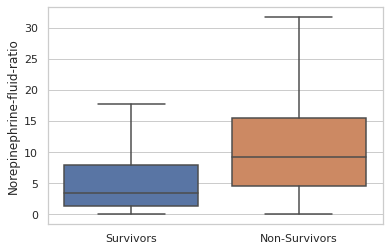

In [216]:
ax = sns.boxplot(x = intake['died07'],y=intake['nf_ratio'], showfliers=False)
ax.set_xticklabels(['Survivors', 'Non-Survivors'])
ax.set(xlabel = '', ylabel = 'Norepinephrine-fluid-ratio')
plt.savefig('img/boxplot_survival.png')